# FE-520 Final Project
### 12/15/2023
### Project Team 11: Lorenzo Ausiello, Fabrizio Dimino, Latika Khanna, Samuele Mugnai, Lorenzo Spinazzi

#### Packages Used

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
from scipy.optimize import brentq
import yfinance as yf

#### Class Containing All Functions

In [2]:
class OptionCalculator:
    # Initialize the option calculator with stock price (S), strike price (K), risk-free rate (r), and time to maturity (tau)
    def __init__(self, S, K, r, tau):
        self.S = S
        self.K = K
        self.r = r
        self.tau = tau
        
    # Calculate Black-Scholes option prices given a volatility (sigma)
    def BS_price(self, sigma):   
        try:
            # Check if sigma is a float or integer, raise a TypeError if not
            if type(sigma) != int and type(sigma) != float:
                raise TypeError("Volatility must be float/integer")
        except TypeError as e:
            return e
        else:
            # Calculate call and put prices using Black-Scholes formula
            d2 = (math.log(self.S / self.K) + (self.r - 0.5 * sigma**2) * self.tau) / (sigma * math.sqrt(self.tau))
            d1 = d2 + sigma * math.sqrt(self.tau)
            call_price = self.S * norm.cdf(d1) - self.K * math.exp(-self.r * self.tau) * norm.cdf(d2)
            put_price = self.K * math.exp(-self.r * self.tau) * norm.cdf(-d2) - self.S * norm.cdf(-d1)
            return call_price, put_price
            
    # Calculate implied volatility given option price and type (call/put)  
    def BS_implied_vol(self, price, optype):
        try:
            # Check if optype is 'call' or 'put', raise a TypeError if not
            if optype.lower() != "call" and optype.lower() != "put" :
                raise TypeError("Option type should be Call or Put")
             # Check if price is a float or integer, raise a TypeError if not    
            if type(price) not in [int, float]:
                raise TypeError("Price should be an integer or a float")   
        except TypeError as TE:
            return TE
        except AttributeError as TE:
            print("TypeError(Option type should be a string)")
        else:
            def black_scholes_call(sigma):
                d2 = (math.log(self.S / self.K) + (self.r - 0.5 * sigma**2) * self.tau) / (sigma * math.sqrt(self.tau))
                d1 = d2 + sigma * math.sqrt(self.tau)
                call_price = self.S * norm.cdf(d1) - self.K * math.exp(-self.r * self.tau) * norm.cdf(d2)-price
                return call_price
            def black_scholes_put(sigma):
                d2 = (math.log(self.S / self.K) + (self.r - 0.5 * sigma**2) * self.tau) / (sigma * math.sqrt(self.tau))
                d1 = d2 + sigma * math.sqrt(self.tau)
                put_price = self.K * math.exp(-self.r * self.tau) * norm.cdf(-d2) - self.S * norm.cdf(-d1)-price
                return put_price
            if optype.lower()=="call":
                implied_volatility = brentq(black_scholes_call, -10.0, 10.0)
            elif optype.lower()=="put":
                implied_volatility = brentq(black_scholes_put, -10.0, 10.0)
            return implied_volatility
            print(implied_volatility)
    
   # Implement put-call parity to calculate the price of the other option given one option's price
    def PC_parity(self, price, optype):
        try:
            # Check if optype is 'call' or 'put', raise a TypeError if not
            if optype.lower() != "call" and optype.lower() != "put" :
                raise TypeError("Option type should be Call or Put")
            # Check if price is a float or integer, raise a TypeError if not    
            if type(price) not in [int, float]:
                raise TypeError("Price should be an integer or a float")   
        except TypeError as TE:
            return TE
        except AttributeError as TE:
            print("TypeError(Option type should be a string)")
        else:
            put_price = max(price+math.exp(-self.r * self.tau)*self.K-self.S, 0)
            call_price = max(price-math.exp(-self.r * self.tau)*self.K+self.S, 0)
            if optype.lower()=="call":
                return put_price
                print(f"Put Option Price: {put_price}")
            elif optype.lower()=="put":
                return call_price
                print(f"Call Option Price: {call_price}")
    
    # Check for arbitrage opportunities based on call and put prices
    def arbitrage_opportunity(self, call_price, put_price):
        try:
            # Check if call_price and put_price are floats or integers, raise a TypeError if not
            if type(call_price) not in [int, float] or type(put_price) not in [int, float]:
                raise TypeError("Prices should be integers or floats")
        except TypeError as TE:
            return TE
        else:
            # Check for arbitrage opportunities and print the respective message
            if round(call_price-put_price, 4) == round(self.S-math.exp(-self.r * self.tau)*self.K, 4):
                print('There are no arbitrage opportunities')
            elif round(call_price-put_price, 4) < round(self.S-math.exp(-self.r * self.tau)*self.K, 4):
                print(f'Arbitrage opportunity! Long call, short put, short underlying and lend {self.K} at {self.r*100}%')
            elif round(call_price-put_price, 4) > round(self.S-math.exp(-self.r * self.tau)*self.K, 4):
                print(f'Arbitrage opportunity! Short call, long put, long underlying and borrow {self.K} at {self.r*100}%')
    
    # Implement the long straddle strategy by calculating option prices and plotting profit/loss
    # Calculate total cost, generate stock price range, compute profit/loss, and plot the graph
    # Identify breakeven points and display information about profit/loss
    def long_straddle(self, sigma):
        call_price, put_price = self.BS_price(sigma)
        total_cost = call_price + put_price

        # Generate a range of stock prices for the graph
        stock_prices = np.linspace(0, self.K*2, 100)
        
        # Calculate profit/loss for each stock price
        profits_losses = -(call_price - np.maximum(self.K - stock_prices, 0)) - (put_price - np.maximum(stock_prices - self.K, 0))

        # Plot the profit/loss graph
        plt.figure(figsize=(8, 5))
        plt.plot(stock_prices, profits_losses)
        x1 = self.K + total_cost
        x2 = self.K - total_cost
        plt.axvline(x=x1, color='g', linestyle='--', label='Breakeven')
        plt.axvline(x=x2, color='g', linestyle='--')
        plt.title('Straddle Strategy Profit/Loss')
        plt.xlabel('Stock Price')
        plt.ylabel('Profit/Loss')
        plt.legend()
        plt.grid(True)
        plt.xlim(min(stock_prices), max(stock_prices))
        plt.show()
        print(f"Profit if price will be lower than {x2} or higher than {x1}")
        print(f"Loss if price will be between {x2} and {x1}")
        
    # Implement the short straddle strategy by calculating option prices and plotting profit/loss
    # Calculate total cost, generate stock price range, compute profit/loss, and plot the graph
    # Identify breakeven points and display information about profit/loss    
    def short_straddle(self, sigma):
        call_price, put_price = self.BS_price(sigma)
            # Since it's a short straddle, we are selling both call and put
        total_credit = call_price + put_price

            # Generate a range of stock prices for the graph
        stock_prices = np.linspace(0, self.K * 2, 100)
        
            # Calculate profit/loss for each stock price
        profits_losses = (call_price - np.maximum(self.K - stock_prices, 0)) + (put_price - np.maximum(stock_prices - self.K, 0))

            # Plot the profit/loss graph
        plt.figure(figsize=(8, 5))
        plt.plot(stock_prices, profits_losses)
        x1 = self.K + total_credit
        x2 = self.K - total_credit
        plt.axvline(x=x1, color='g', linestyle='--', label='Breakeven')
        plt.axvline(x=x2, color='g', linestyle='--')
        plt.title('Short Straddle Strategy Profit/Loss')
        plt.xlabel('Stock Price')
        plt.ylabel('Profit/Loss')
        plt.legend()
        plt.grid(True)
        plt.xlim(min(stock_prices), max(stock_prices))
        plt.show()
        print(f"Profit if price will be between {x2} and {x1}")
        print(f"Loss if price will be lower than {x2} or higher than {x1} ")
    
    # Implement long call and short put strategy (synthetic long position)
    def synthetic_long_position(self, sigma):
        call_price, _ = self.BS_price(sigma)  # Get the price of the call option
        
        # Let's assume the put option is shorted at the same strike price and expiration
        put_price = -self.BS_price(sigma)[1]  # Negative value to represent shorting the put
        
        # Net cost or credit of the position
        net_cost_credit = call_price + put_price

        # Generate a range of stock prices for the graph
        stock_prices = np.linspace(0, self.K * 2, 100)
        
        # Calculate profit/loss for each stock price
        profits_losses = stock_prices - self.K - (net_cost_credit)

        # Plot the profit/loss graph
        plt.figure(figsize=(8, 5))
        plt.plot(stock_prices, profits_losses)
        plt.axvline(x=self.K+net_cost_credit, color='g', linestyle='-', label='Breakeven')
        plt.title('Synthetic Long Position Profit/Loss')
        plt.xlabel('Stock Price')
        plt.ylabel('Profit/Loss')
        plt.legend()
        plt.grid(True)
        plt.xlim(min(stock_prices), max(stock_prices))
        plt.show()
        print(f"Net Cost/Credit: {net_cost_credit}")
        print(f"Profit if price will higher than {self.K+net_cost_credit}")
        print(f"Loss if price will be lower than {self.K+net_cost_credit}")
        
    # Implement short call and long put strategy (synthetic short position)
    def synthetic_short_position(self, sigma):
        call_price = -self.BS_price(sigma)[0]  # Get the price of the call option
        
        # Let's assume the put option is shorted at the same strike price and expiration
        put_price = self.BS_price(sigma)[1]  # Negative value to represent shorting the put
        
        # Net cost or credit of the position
        net_cost_credit = call_price + put_price

        # Generate a range of stock prices for the graph
        stock_prices = np.linspace(0, self.K * 2, 100)
        
        # Calculate profit/loss for each stock price
        profits_losses = self.K - stock_prices - (net_cost_credit)

        # Plot the profit/loss graph
        plt.figure(figsize=(8, 5))
        plt.plot(stock_prices, profits_losses)
        plt.axvline(x=self.K - net_cost_credit, color='g', linestyle='-', label='Breakeven')
        plt.title('Synthetic Short Position Profit/Loss')
        plt.xlabel('Stock Price')
        plt.ylabel('Profit/Loss')
        plt.legend()
        plt.grid(True)
        plt.xlim(min(stock_prices), max(stock_prices))
        plt.show()
        print(f"Net Cost/Credit: {net_cost_credit}")
        print(f"Loss if price will higher than {self.K - net_cost_credit}")
        print(f"Profit if price will be lower than {self.K - net_cost_credit}")

    # This is a function that creates a stock price evolution binomial tree using Cox-Ross-Rubinestein scheme
    def CRR(self, sigma, N):
        try:
            if type(sigma) != float and type(sigma) != int:
                raise TypeError("Volatility must be float/integer")
            if type(N) != int:
                raise TypeError("Number of steps must be an integer")
        except TypeError as e:
            return e
        else:
            # Initialize matrix with columns = N + 1, rows = (N * 2) + 1
            CRR = np.zeros(((N * 2 + 1), (N + 1)))
            # Center starting node = S0
            center = math.floor(len(CRR) / 2)
            CRR[center, 0] = self.S
            # CRR parameters
            dt = self.tau / N
            u = math.exp(sigma * math.sqrt(dt))
            d = math.exp(-sigma * math.sqrt(dt))
            q = (math.exp(self.r * dt) - d) / (u - d)
            # Looping through one column at a time
            for i in range(1, np.shape(CRR)[1] + 1):
                # The following lines indexes what row range to look at in every column skipping cells that should = 0
                # Note this could be made more efficient as the run time complexity is approx O(n^2) given the nested for-loops
                # Luckily, N will not have to be too large given the tree method price and BS converge around N = 200
                x = list(range(center - (i - 1), center + i, 2))
                y = i - 1
                CRR[x,y] = self.S
                start = center - (i - 1)
                end = center + (i - 1)
                # Amount of "up-moves" for each node
                x = list(range((i-1), -1, -1))
                temp = []
                for z in x:
                    temp.extend([z, 0])
                x = temp
                count = -1
                # Asjusting price for each indexed node with the corresponding up-move value
                for j in range(start, end + 1):
                    count = count + 1
                    CRR[j, (i - 1)] = CRR[j, (i - 1)] * u**(x[count]) * d**((i - 1) - x[count])
            # Returning tree in matrix form
            return(CRR)

    # This function calculates "today's" European call option price given some parameters
    # Backwards dynamic (recursive) programming (starting at CRR terminal nodes [ST - K]+ --> first node V0)
    def Euro_Call_CRR(self, tree, sigma):
        try:
            if type(sigma) != int and type(sigma) != float:
                raise TypeError("Volatility must be float/integer")
        except TypeError as e:
            return e
        else:
            # CRR parameters
            N = np.shape(tree)[1] - 1
            dt = self.tau / N
            u = math.exp(sigma * math.sqrt(dt))
            d = math.exp(-sigma * math.sqrt(dt))
            q = (math.exp(self.r * dt) - d) / (u - d)
            V = np.zeros(((N * 2 + 1), (N + 1)))
            center = math.floor(len(tree) / 2)
            # Payoff = [ST - K]+
            for i in range(0, np.shape(tree)[0], 1):
                payoff = tree[i, (np.shape(tree)[1] - 1)] - self.K
                V[i, (np.shape(tree)[1] - 1)] = payoff if payoff > 0 else 0
            # Same procedure as CRR
            for j in range(np.shape(tree)[1] - 2, -1, -1):  
                start = center - j
                end = center + j
                x = [1] * (j + 1)
                temp = []
                for z in x:
                    temp.extend([z, 0])
                x = temp
                count = -1
                # V = PV(E[V]) = e^-rt * (V("up") * q + V("down") * (1 - q))
                for k in range(start, end + 1):
                    count = count + 1
                    V[k, j] = x[count] * math.exp(-self.r * dt) * ((q * V[(k - 1), (j + 1)]) + (1 - q) * V[(k + 1), (j + 1)])
            # Returns both fair price of call option (starting node) and the tree evolution
            return(V, V[center, 0])

    # This function calculates "today's" European put option price given some parameters
    # Same procedure as Euro_Call_CRR
    def Euro_Put_CRR(self, tree, sigma):
        try:
            if type(sigma) != int and type(sigma) != float:
                raise TypeError("Volatility must be float/integer")
        except TypeError as e:
            return e
        else:
            N = np.shape(tree)[1] - 1
            dt = self.tau / N
            u = math.exp(sigma * math.sqrt(dt))
            d = math.exp(-sigma * math.sqrt(dt))
            q = (math.exp(self.r * dt) - d) / (u - d)
            V = np.zeros(((N * 2 + 1), (N + 1)))
            center = math.floor(len(tree) / 2)
            for i in range(0, np.shape(tree)[0], 1):
                # Payoff = [K - ST]+
                # Only performs payoff function if CRR terminal node (ST) is not 0
                if tree[i, (np.shape(tree)[1] - 1)] != 0:
                    payoff = self.K - tree[i, (np.shape(tree)[1] - 1)]
                    V[i, (np.shape(tree)[1] - 1)] = payoff if payoff > 0 else 0
            for j in range(np.shape(tree)[1] - 2, -1, -1):  
                start = center - j
                end = center + j
                x = [1] * (j + 1)
                temp = []
                for z in x:
                    temp.extend([z, 0])
                    x = temp
                count = -1
                for k in range(start, end + 1):
                    count = count + 1
                    V[k, j] = x[count] * math.exp(-self.r * dt) * ((q * V[(k - 1), (j + 1)]) + (1 - q) * V[(k + 1), (j + 1)])
            return(V, V[center, 0])

    # Style feature for dataframe output (removes all zeros so the CRR tree evolution is more clear)
    def remove_zeros(self, cell):
        cell = '' if cell == 0 else cell
        return cell

    # Function demonstrating the convergence of call option price derived from binomial tree method with Black Scholes price
    # Takes input equal to the number of maximum tree steps you want
    # Recommendation: use at least 200 steps to clearly see the convergence dynamic
    def plot_convergence_call(self, N, sigma):
        try:
            if type(sigma) != float and type(sigma) != int:
                raise TypeError("Volatility must be float/integer")
            if type(N) != int:
                raise TypeError("Number of steps must be an integer")
        except TypeError as e:
            return e
        else:
            steps = list(range(1, N, 5))
            call_price = [0] * len(steps)
            error = [0] * len(steps)
            BS_call, BS_put = self.BS_price(sigma)
            for i in range(len(steps)):
                binomial_tree = self.CRR(sigma, steps[i])
                call_price[i] = float(self.Euro_Call_CRR(binomial_tree, sigma)[1])
                error[i] = abs(call_price[i] - BS_call) / BS_call
            fig, graphs = plt.subplots(1,2,sharey = False, sharex = False, figsize = (15,5))
            graphs[0].plot(steps, call_price, color = "green")
            graphs[0].axhline(y=BS_call, color='red', linestyle='--', label='Black Scholes Price')
            graphs[0].set_title("Binomial Tree European Call Option Price Convergence with Black Scholes")
            graphs[0].set_xlabel("Number of Tree Steps")
            graphs[0].set_ylabel("Option Price")
            graphs[0].legend()
            graphs[1].plot(steps, error)
            graphs[1].axhline(y=0, color='red', linestyle='--', label='0 Error')
            graphs[1].set_title("Absolute Relative Pricing Error")
            graphs[1].set_xlabel("Number of Tree Steps")
            graphs[1].set_ylabel("Error (%)")
            graphs[1].legend()
            plt.tight_layout()

    # Same as plot_convergence_call but for a European put option
    def plot_convergence_put(self, N, sigma):
        try:
            if type(sigma) != float and type(sigma) != int:
                raise TypeError("Volatility must be float/integer")
            if type(N) != int:
                raise TypeError("Number of steps must be an integer")
        except TypeError as e:
            return e
        else:
            steps = list(range(1, N, 5))
            put_price = [0] * len(steps)
            error = [0] * len(steps)
            BS_call, BS_put = self.BS_price(sigma)
            for i in range(len(steps)):
                binomial_tree = self.CRR(sigma, steps[i])
                put_price[i] = float(self.Euro_Put_CRR(binomial_tree, sigma)[1])
                error[i] = abs(put_price[i] - BS_put) / BS_put
            fig, graphs = plt.subplots(1,2,sharey = False, sharex = False, figsize = (15,5))
            graphs[0].plot(steps, put_price, color = "green")
            graphs[0].axhline(y=BS_put, color='red', linestyle='--', label='Black Scholes Price')
            graphs[0].set_title("Binomial Tree European Put Option Price Convergence with Black Scholes")
            graphs[0].set_xlabel("Number of Tree Steps")
            graphs[0].set_ylabel("Option Price")
            graphs[0].legend()
            graphs[1].plot(steps, error)
            graphs[1].axhline(y=0, color='red', linestyle='--', label='0 Error')
            graphs[1].set_title("Absolute Relative Pricing Error")
            graphs[1].set_xlabel("Number of Tree Steps")
            graphs[1].set_ylabel("Error (%)")
            graphs[1].legend()
            plt.tight_layout()

    # Defining a function to calculate call and put price using Monte-Carlo Simulation
    def mcs_price(self, sigma, no_of_intervals, no_of_paths, display_plot:bool):
        
        # Using try-except block to raise an error if the input parameters are not integers
        try:
            if type(no_of_intervals) != int or type(no_of_paths) != int:
                raise TypeError
        except TypeError:
            print("Number of intervals and number of paths should be integer")
            
        else:    
                
            # Initiating a dictionary to store pay-offs for every simulated path
            pay_offs = {'call': [] , 'put': []}
            
            if display_plot == True:
                # Initialising a graph figure
                plt.figure(figsize=(8, 5))
                
            for path in range(no_of_paths):
                # Initialising a list to store the prices at each interval
                interval_prices = [self.S]
            
                # Using a nested for loop to iterate over every interval in each path
                for i in range(no_of_intervals):
                    interval_prices.append(interval_prices[-1]*math.exp((self.r - (sigma**2)/2)*(self.tau/no_of_intervals) + sigma*np.random.normal()*((self.tau/no_of_intervals)**0.5)))
                
                if display_plot == True:    
                    # Plotting the line graph for each path
                    plt.plot(interval_prices)
                     
                # Using the stock price at the end of a path, calculating the pay-off values and storing them in a dictionary 
                maturity_stock_price = interval_prices[-1]
                pay_offs['call'].append(max(maturity_stock_price - self.K, 0))
                pay_offs['put'].append(max(self.K - maturity_stock_price, 0))
            
            # Calculating the option price by taking the average of all simulated pay-offs and discounting it
            call_price = np.mean(pay_offs['call'])*math.exp(-self.r * self.tau)
            put_price = np.mean(pay_offs['put'])*math.exp(-self.r * self.tau)
            
            if display_plot == True:
                # Specifying the details of graph figure
                plt.title('Monte-Carlo simulations')
                plt.xlabel('Intervals')
                plt.ylabel('Stock Price')
                plt.show()
            
            return call_price, put_price
        
    # Defining a function to do a sensitivity analysis for a given array of volatility values
    def sensitivity_analysis(self, option_type, calculation_method, volatility_values, no_of_intervals=None, no_of_paths=None):
        
        # Initiating a list to store the different prices of an option
        option_prices = []

        # Iterating over each of the volatility value
        for value in volatility_values:
            
            # Specifying the if condition to use the appropriate function for calculating the price and raising errors if the inputs are not proper
            if calculation_method == "mcs":
                if no_of_intervals is None or no_of_paths is None:
                    raise ValueError("For monte-carlo based calculations, please specify no_of_intervals and no_of_paths.")
                
                # Setting the display_plot parameter to "False" to avoid multiple graphs of MCS based prices
                call_price, put_price = self.mcs_price(value, no_of_intervals, no_of_paths, False)
                
            elif calculation_method == "bsm":
                call_price, put_price = self.BS_price(value)
                
            else:
                raise ValueError("Please specify the pricing method as either 'mcs' or 'bsm'.")

            # Updating the option price list as per the type of option specified
            if option_type == 'call':
                option_prices.append(call_price)
                
            if option_type == 'put': 
                option_prices.append(put_price)

        # Plotting the graph for sensitivity analysis
        plt.figure(figsize=(8, 5))
        plt.plot(volatility_values, option_prices, marker='o')
        plt.title(f'Volatility based Sensitivity Analysis for {option_type.capitalize()} Option Price')
        plt.xlabel("Volatility")
        plt.ylabel(f'{option_type.capitalize()} Option Price')
        plt.show()



# Extra function not part of class for stylistic purposes for dataframe output:
def in_the_money(cell):
    cell_color = 'background-color: green' if cell > 0 else ''
    num_color = 'color: white' if cell > 0 else ''
    return f'{cell_color}; {num_color}'
    
    

#### Examples

For all examples we will assume the following parameters:

$$S_0 = 100 $$
$$K = 100$$
$$r = 0.10 $$
$$\tau = 2 $$
$$\sigma = 0.2 $$

In [3]:
option = OptionCalculator(100,100,0.1,2)
sigma = 0.2

##### BS_price

In [4]:
# Black Scholes European call and put prices
call_price, put_price = option.BS_price(sigma)
print(f"Call Option price: {call_price}")
print(f"Put Option price: {put_price}")

Call Option price: 21.71936711548674
Put Option price: 3.5924424232849326


##### BS_implied_vol

In [5]:
# Black Scholes implied volatility
option.BS_implied_vol(float(call_price), "call")

0.19999999999999965

##### PC_parity

In [6]:
# Deriving call option price using Put Call Parity
# Note should equal our previously defined call price = 21.71936711548674
option.PC_parity(float(put_price), "put")

21.719367115486747

##### arbitrage_opportunity

In [7]:
option.arbitrage_opportunity(float(call_price), float(put_price))

There are no arbitrage opportunities


In [8]:
option.arbitrage_opportunity(25.71936711548674, float(put_price))

Arbitrage opportunity! Short call, long put, long underlying and borrow 100 at 10.0%


In [9]:
option.arbitrage_opportunity(12.71936711548674, float(put_price))

Arbitrage opportunity! Long call, short put, short underlying and lend 100 at 10.0%


##### option_straddle

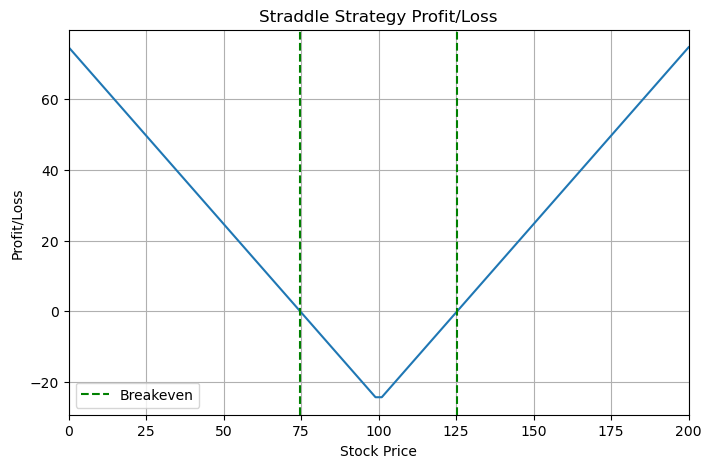

Profit if price will be lower than 74.68819046122833 or higher than 125.31180953877167
Loss if price will be between 74.68819046122833 and 125.31180953877167


In [10]:
option.long_straddle(0.2)

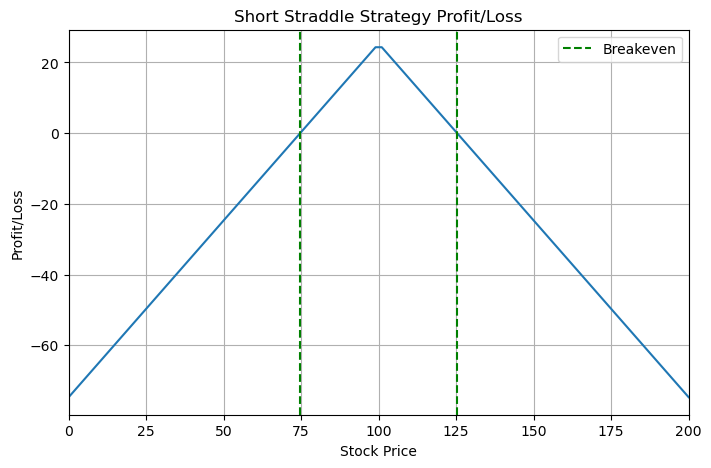

Profit if price will be between 74.68819046122833 and 125.31180953877167
Loss if price will be lower than 74.68819046122833 or higher than 125.31180953877167 


In [11]:
option.short_straddle(0.2)

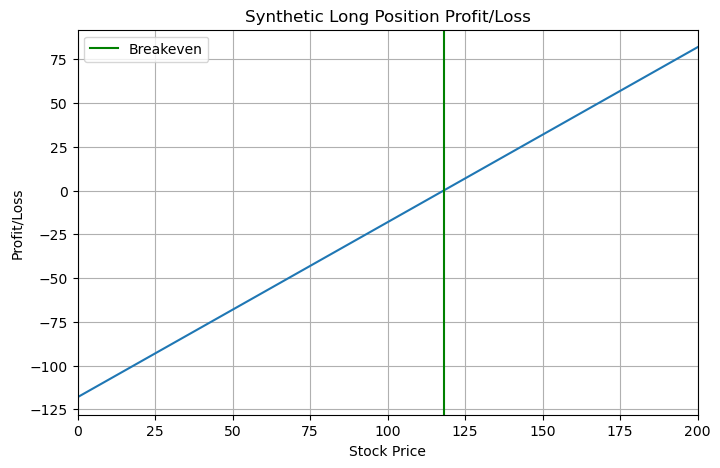

Net Cost/Credit: 18.126924692201808
Profit if price will higher than 118.12692469220181
Loss if price will be lower than 118.12692469220181


In [12]:
option.synthetic_long_position(0.2)

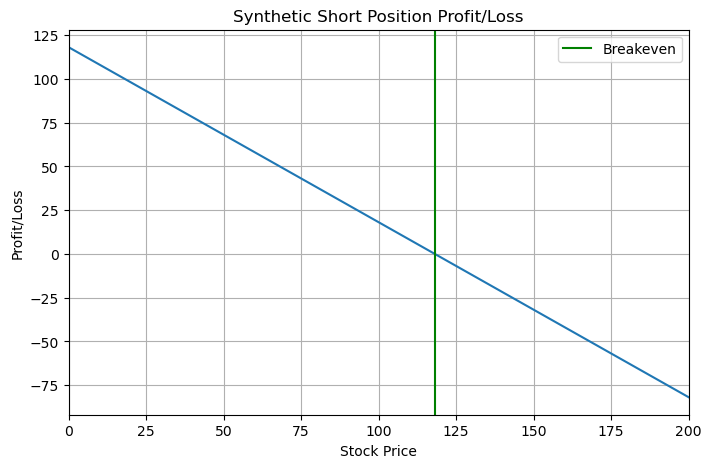

Net Cost/Credit: -18.126924692201808
Loss if price will higher than 118.12692469220181
Profit if price will be lower than 118.12692469220181


In [13]:
option.synthetic_short_position(0.2)

For all examples we will assume the following parameters:

$$S_0 = 100 $$
$$K = 90$$
$$r = 0.02 $$
$$\tau = 1 $$
$$\sigma = 0.2 $$
$$N = 10 $$

In [14]:
option = OptionCalculator(100,90,0.02,1)
N = 10

##### CRR (and remove_zeros)

In [15]:
# Dataframe of CRR function output
tree = pd.DataFrame(option.CRR(sigma,N))
# Removing zeros for better visualization
tree.applymap(option.remove_zeros)

,0,1,2,3,4,5,6,7,8,9,10
0,,,,,,,,,,,188.222678
1,,,,,,,,,,176.687063,
2,,,,,,,,,165.858433,,165.858433
3,,,,,,,,155.693458,,155.693458,
4,,,,,,,146.151464,,146.151464,,146.151464
5,,,,,,137.19427,,137.19427,,137.19427,
6,,,,,128.786037,,128.786037,,128.786037,,128.786037
7,,,,120.89312,,120.89312,,120.89312,,120.89312,
8,,,113.483936,,113.483936,,113.483936,,113.483936,,113.483936
9,,106.528839,,106.528839,,106.528839,,106.528839,,106.528839,


##### Euro_Call_CRR (and in_the_money)

In [16]:
# CRR tree in matrix form to be inputted into Euro_Call_CRR
tree = option.CRR(sigma,N)
# Dataframe of Euro_Call_CRR function output
Euro_tree = pd.DataFrame(option.Euro_Call_CRR(tree, 0.2)[0])
# Highlighting in green when the option is in the money
Euro_tree.style.applymap(in_the_money)

,0,1,2,3,4,5,6,7,8,9,10
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,98.222678
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,86.866884,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,76.217714,0.000000,75.858433
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,66.231841,0.000000,65.873278,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,56.868591,0.000000,56.510744,0.000000,56.151464
5,0.000000,0.000000,0.000000,0.000000,0.000000,48.089785,0.000000,47.732653,0.000000,47.374090,0.000000
6,0.000000,0.000000,0.000000,0.000000,39.888632,0.000000,39.503165,0.000000,39.145318,0.000000,38.786037
7,0.000000,0.000000,0.000000,32.340953,0.000000,31.846850,0.000000,31.431503,0.000000,31.072940,0.000000
8,0.000000,0.000000,25.577771,0.000000,24.922453,0.000000,24.317729,0.000000,23.843217,0.000000,23.483936
9,0.000000,19.719911,0.000000,18.916720,0.000000,18.097555,0.000000,17.301026,0.000000,16.708659,0.000000


##### Euro_Put_CRR (and in_the_money)

In [17]:
# CRR tree in matrix form to be inputted into Euro_Put_CRR
tree = option.CRR(sigma,N)
# Dataframe of Euro_Put_CRR function output
Euro_tree = pd.DataFrame(option.Euro_Put_CRR(tree, sigma)[0])
# Highlighting in green when the option is in the money
Euro_tree.style.applymap(in_the_money)

,0,1,2,3,4,5,6,7,8,9,10
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.029049,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.196613,0.000000,0.058215,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.665294,0.000000,0.364971,0.000000,0.116666,0.000000,0.000000,0.000000,0.000000
9,0.000000,1.585565,0.000000,1.136660,0.000000,0.673201,0.000000,0.233803,0.000000,0.000000,0.000000


##### plot_convergence_call

For the convergence plots we will use the same values and iterate through different step sizes from 1 - 200 in itervals of 5

In [18]:
N = 200

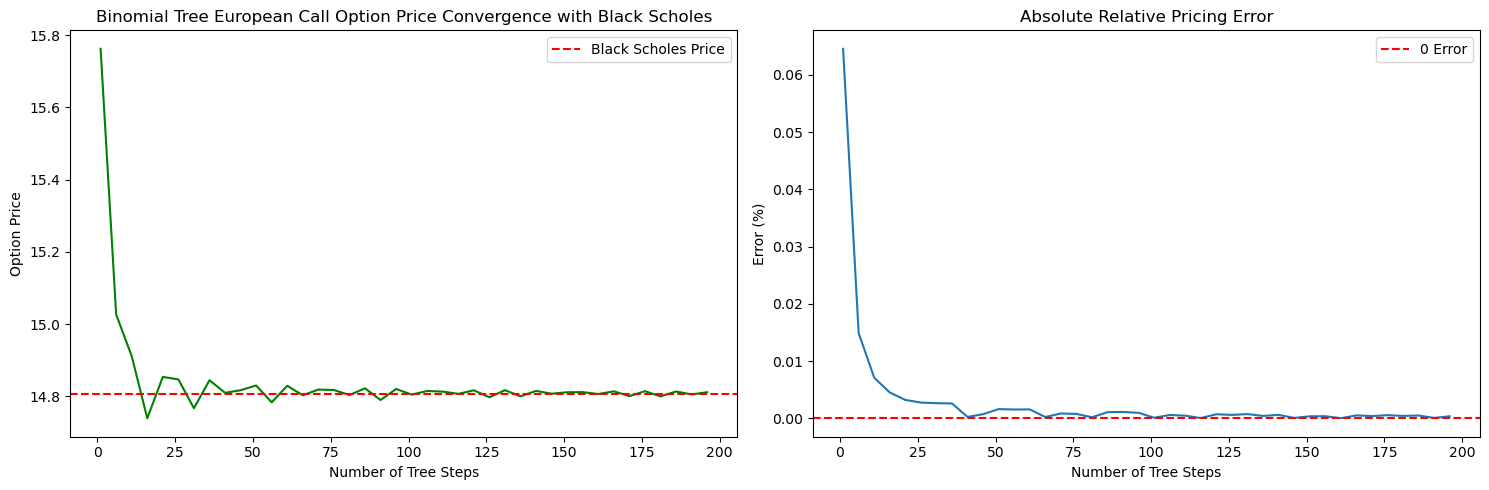

In [19]:
# Call option convergence
option.plot_convergence_call(N, sigma)

##### plot_convergence_put

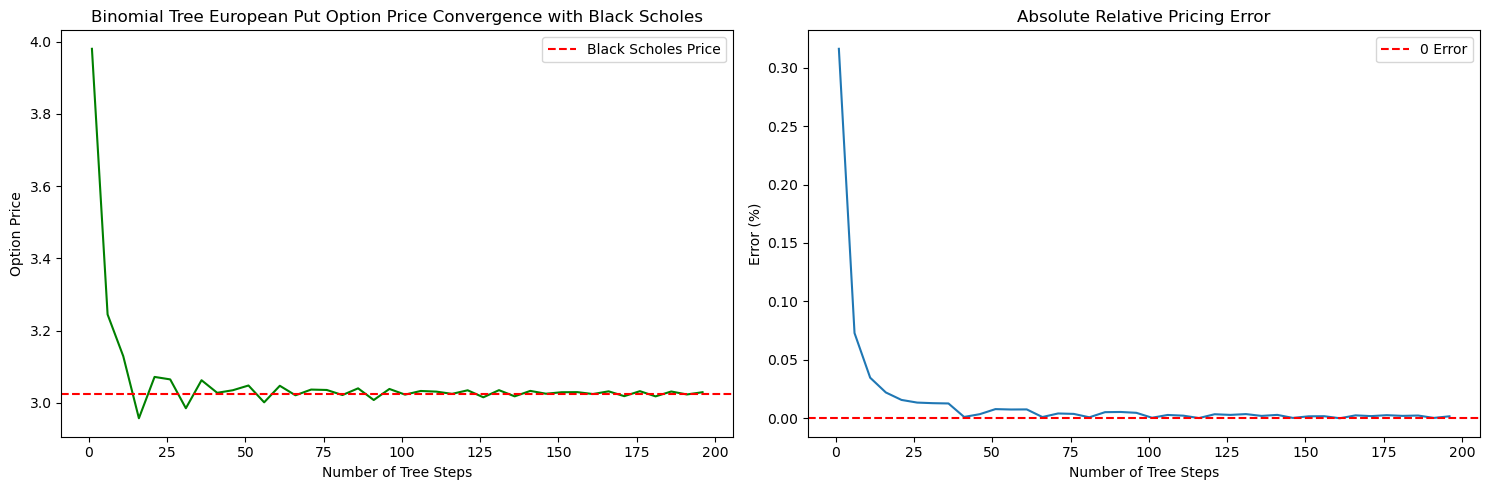

In [20]:
# Put option convergence
option.plot_convergence_put(N, sigma)

##### mcs_price

For the Monte Carlo method of pricing the options we will use the same parameters with 10,000 simulations containg 50 steps (intervals) per simulated path

In [21]:
simulations = 10000
m = 50

In [22]:
# Testing Monte-Carlo Simulation function
call_price, put_price = option.mcs_price(sigma, m, simulations, "True")
print(f"Call Option price: {call_price}")
print(f"Put Option price: {put_price}")

Call Option price: 14.988123949566928
Put Option price: 2.925482087343072


#### sensitivity_analysis


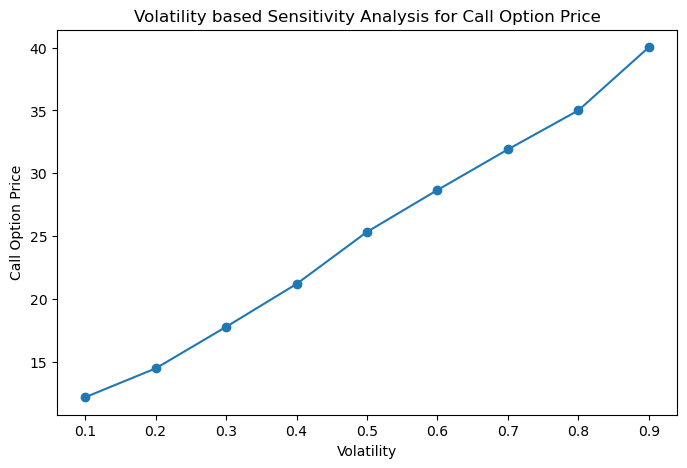

In [23]:
# Testing sensitivity analysis function with call option price calculated as per Monte-Carlo Simulations: 
volatility_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
sensitvity_analysis = option.sensitivity_analysis('call', 'mcs', volatility_values, m, simulations)

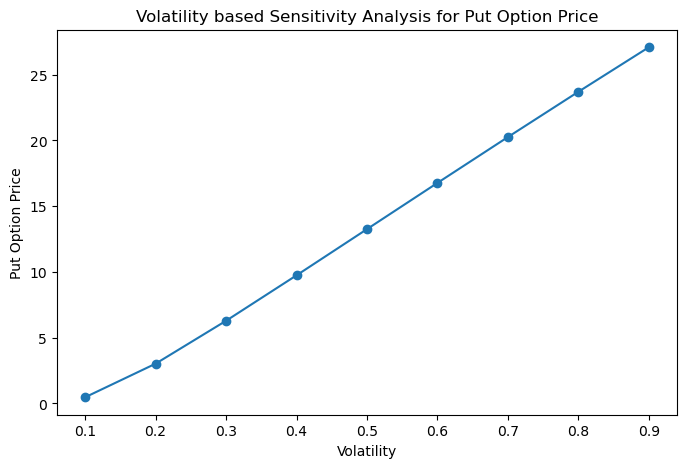

In [24]:
# Testing sensitivity analysis function with put option price calculated as per Black-Scholes Model: 
sensitvity_analysis = option.sensitivity_analysis('put', 'bsm', volatility_values)

#### Error Handling

In this section we will exemplify some error handling we incorporated into our functions

In [25]:
option.BS_price("hello")

TypeError('Volatility must be float/integer')

In [26]:
option.BS_implied_vol(21.71936711548674, 22)

TypeError(Option type should be a string)


In [27]:
option.BS_implied_vol(21.71936711548674, "hello")

TypeError('Option type should be Call or Put')

In [28]:
option.BS_implied_vol("hello", "put")

TypeError('Price should be an integer or a float')

In [29]:
option.PC_parity(3.5924424232849326, 22)

TypeError(Option type should be a string)


In [30]:
option.PC_parity(3.5924424232849326, "hello")

TypeError('Option type should be Call or Put')

In [31]:
option.PC_parity("hello", "put")

TypeError('Price should be an integer or a float')

In [32]:
option.arbitrage_opportunity("hello", 3.5)

TypeError('Prices should be integers or floats')

In [33]:
option.arbitrage_opportunity(3.5, "hello")

TypeError('Prices should be integers or floats')

In [34]:
option.CRR("sigma", 5)

TypeError('Volatility must be float/integer')

In [35]:
option.CRR(0.20, 0.50)

TypeError('Number of steps must be an integer')

In [36]:
matrix = option.CRR(0.20, 10)
option.Euro_Call_CRR(matrix, "volatility is 5%")

TypeError('Volatility must be float/integer')

In [37]:
option.Euro_Put_CRR(matrix, "5%")

TypeError('Volatility must be float/integer')

In [38]:
option.plot_convergence_call(20.5, 0.30)

TypeError('Number of steps must be an integer')

In [39]:
option.plot_convergence_call(20, "0.30")

TypeError('Volatility must be float/integer')

In [40]:
option.plot_convergence_put(20.5, 0.30)

TypeError('Number of steps must be an integer')

In [41]:
option.plot_convergence_put(20, "0.30")

TypeError('Volatility must be float/integer')

In [42]:
option.mcs_price(0.2, "five", 10000, "True")

Number of intervals and number of paths should be integer


In [43]:
option.mcs_price(0.5, 5, "hundred", "True")

Number of intervals and number of paths should be integer


## Dataset

In this section we will work with downloading real financial data from Yahoo Finance and implementing this data into some of our functions.

In [44]:
aapl = pd.read_excel('C:/Users/loaus/OneDrive - stevens.edu/STEVENS/Python/AAPL.xlsx')
aapl.head()

,Contract Name,Last Trade Date,Strike,Last Price,S0,interest rate
0,AAPL231215C00065000,2023-12-01 2:49PM EST,65.0,126.25,195.71,0.0532
1,AAPL231215C00070000,2023-12-06 3:51PM EST,70.0,122.38,195.71,0.0532
2,AAPL231215C00075000,2023-12-06 3:51PM EST,75.0,117.41,195.71,0.0532
3,AAPL231215C00080000,2023-12-04 12:48PM EST,80.0,108.89,195.71,0.0532
4,AAPL231215C00085000,2023-11-30 3:50PM EST,85.0,104.70,195.71,0.0532


In [45]:
options = {}
opt_prices = {}
for i in range(120):   
    options[aapl.loc[i, 'Contract Name']] = OptionCalculator(aapl.loc[i, 'S0'],
                                                              aapl.loc[i, 'Strike'],
                                                              aapl.loc[i, 'interest rate'],
                                                              3/360)
    opt_prices[aapl.loc[i, 'Contract Name']] = aapl.loc[i, 'Last Price']

In [46]:
options

{'AAPL231215C00065000': <__main__.OptionCalculator at 0x1a9c9c05b70>,
 'AAPL231215C00070000': <__main__.OptionCalculator at 0x1a9cf31abf0>,
 'AAPL231215C00075000': <__main__.OptionCalculator at 0x1a9cf319c00>,
 'AAPL231215C00080000': <__main__.OptionCalculator at 0x1a9cf319c30>,
 'AAPL231215C00085000': <__main__.OptionCalculator at 0x1a9cf319e70>,
 'AAPL231215C00090000': <__main__.OptionCalculator at 0x1a9cf319ed0>,
 'AAPL231215C00095000': <__main__.OptionCalculator at 0x1a9cf319f30>,
 'AAPL231215C00100000': <__main__.OptionCalculator at 0x1a9cf319f60>,
 'AAPL231215C00105000': <__main__.OptionCalculator at 0x1a9cf318e20>,
 'AAPL231215C00110000': <__main__.OptionCalculator at 0x1a9cf318eb0>,
 'AAPL231215C00115000': <__main__.OptionCalculator at 0x1a9cf31a680>,
 'AAPL231215C00120000': <__main__.OptionCalculator at 0x1a9cf31a620>,
 'AAPL231215C00125000': <__main__.OptionCalculator at 0x1a9cf31a710>,
 'AAPL231215C00130000': <__main__.OptionCalculator at 0x1a9cf318c40>,
 'AAPL231215C0013500

In [47]:
opt_prices

{'AAPL231215C00065000': 126.25,
 'AAPL231215C00070000': 122.38,
 'AAPL231215C00075000': 117.41,
 'AAPL231215C00080000': 108.89,
 'AAPL231215C00085000': 104.7,
 'AAPL231215C00090000': 103.41,
 'AAPL231215C00095000': 94.65,
 'AAPL231215C00100000': 96.05,
 'AAPL231215C00105000': 86.4,
 'AAPL231215C00110000': 84.57,
 'AAPL231215C00115000': 76.33,
 'AAPL231215C00120000': 75.35,
 'AAPL231215C00125000': 69.26,
 'AAPL231215C00130000': 65.7,
 'AAPL231215C00135000': 60.33,
 'AAPL231215C00140000': 55.95,
 'AAPL231215C00145000': 49.94,
 'AAPL231215C00150000': 45.88,
 'AAPL231215C00152500': 43.43,
 'AAPL231215C00155000': 40.91,
 'AAPL231215C00157500': 35.79,
 'AAPL231215C00160000': 36.0,
 'AAPL231215C00162500': 32.58,
 'AAPL231215C00165000': 31.25,
 'AAPL231215C00167500': 27.4,
 'AAPL231215C00170000': 26.0,
 'AAPL231215C00172500': 23.59,
 'AAPL231215C00175000': 20.94,
 'AAPL231215C00177500': 18.5,
 'AAPL231215C00180000': 16.25,
 'AAPL231215C00182500': 13.65,
 'AAPL231215C00185000': 11.05,
 'AAPL231

In [48]:
aapl_prices = yf.download('AAPL', period='10y')
aapl_prices['Returns'] = aapl_prices['Adj Close'].pct_change()
sigma = aapl_prices['Returns'].std()*math.sqrt(252)
sigma

[*********************100%***********************]  1 of 1 completed


0.28409283602617036

In [49]:
call = list(options.items())[:60]
put = list(options.items())[60:]
for keys, values in call:
    print(f"{keys} Price = {values.BS_price(sigma)[0]}")
for keys, values in put:
    print(f"{keys} Price = {values.BS_price(sigma)[1]}")



AAPL231215C00065000 Price = 130.7388102799161
AAPL231215C00070000 Price = 125.74102645529425
AAPL231215C00075000 Price = 120.7432426306724
AAPL231215C00080000 Price = 115.74545880605056
AAPL231215C00085000 Price = 110.74767498142872
AAPL231215C00090000 Price = 105.74989115680688
AAPL231215C00095000 Price = 100.75210733218505
AAPL231215C00100000 Price = 95.7543235075632
AAPL231215C00105000 Price = 90.75653968294137
AAPL231215C00110000 Price = 85.75875585831952
AAPL231215C00115000 Price = 80.76097203369768
AAPL231215C00120000 Price = 75.76318820907584
AAPL231215C00125000 Price = 70.765404384454
AAPL231215C00130000 Price = 65.76762055983215
AAPL231215C00135000 Price = 60.769836735210305
AAPL231215C00140000 Price = 55.772052910588485
AAPL231215C00145000 Price = 50.77426908596664
AAPL231215C00150000 Price = 45.77648526134479
AAPL231215C00152500 Price = 43.27759334903388
AAPL231215C00155000 Price = 40.77870143672297
AAPL231215C00157500 Price = 38.27980952441203
AAPL231215C00160000 Price = 35

In [50]:
call = list(options.items())[:60]
put = list(options.items())[60:]
for keys, values in call: 
    print(f"{keys} Implied Volatility = {values.BS_implied_vol(float(opt_prices[keys]), 'call')}")
for keys, values in put:
    print(f"{keys} Implied Volatility = {values.BS_implied_vol(float(opt_prices[keys]), 'put')}")

AAPL231215C00065000 Implied Volatility = 3.960701017865413e-13
AAPL231215C00070000 Implied Volatility = 1.308738605292482e-12
AAPL231215C00075000 Implied Volatility = 2.0463068941627668e-14
AAPL231215C00080000 Implied Volatility = 1.9785825381426544e-13
AAPL231215C00085000 Implied Volatility = 1.76854800247686e-12
AAPL231215C00090000 Implied Volatility = 2.402996573380948e-13
AAPL231215C00095000 Implied Volatility = 1.792261801291067e-14
AAPL231215C00100000 Implied Volatility = 3.5212757165564277
AAPL231215C00105000 Implied Volatility = 3.974903424188545e-13
AAPL231215C00110000 Implied Volatility = 5.173968201213214e-13
AAPL231215C00115000 Implied Volatility = 1.4732807295715663e-12
AAPL231215C00120000 Implied Volatility = 7.754196970567878e-13
AAPL231215C00125000 Implied Volatility = 7.5337018117436e-13
AAPL231215C00130000 Implied Volatility = 1.1884195661182868e-12
AAPL231215C00135000 Implied Volatility = 2.9163156875065506e-13
AAPL231215C00140000 Implied Volatility = 1.7607795785525

In [51]:
call = list(options.items())[:60]
put = list(options.items())[60:]
for keys, values in call: 
    print(f"{keys} Put Price = {values.PC_parity(float(opt_prices[keys]), 'call')}")
for keys, values in put:
    print(f"{keys} Call Price = {values.PC_parity(float(opt_prices[keys]), 'put')}")

AAPL231215C00065000 Put Price = 0
AAPL231215C00070000 Put Price = 0
AAPL231215C00075000 Put Price = 0
AAPL231215C00080000 Put Price = 0
AAPL231215C00085000 Put Price = 0
AAPL231215C00090000 Put Price = 0
AAPL231215C00095000 Put Price = 0
AAPL231215C00100000 Put Price = 0.2956764924367974
AAPL231215C00105000 Put Price = 0
AAPL231215C00110000 Put Price = 0
AAPL231215C00115000 Put Price = 0
AAPL231215C00120000 Put Price = 0
AAPL231215C00125000 Put Price = 0
AAPL231215C00130000 Put Price = 0
AAPL231215C00135000 Put Price = 0
AAPL231215C00140000 Put Price = 0.1779470894115036
AAPL231215C00145000 Put Price = 0
AAPL231215C00150000 Put Price = 0.10351473865520688
AAPL231215C00152500 Put Price = 0.15240665096612815
AAPL231215C00155000 Put Price = 0.13129856327702782
AAPL231215C00157500 Put Price = 0
AAPL231215C00160000 Put Price = 0.21908238789887946
AAPL231215C00162500 Put Price = 0
AAPL231215C00165000 Put Price = 0.4668662125207277
AAPL231215C00167500 Put Price = 0
AAPL231215C00170000 Put Pri

In [52]:
call = list(options.items())[:60]
put = list(options.items())[60:]
for c, p in zip(call, put): 
    print(f"{c[0]} and {p[0]} = {c[1].arbitrage_opportunity(float(opt_prices[c[0]]), float(opt_prices[p[0]]))}")

Arbitrage opportunity! Long call, short put, short underlying and lend 65.0 at 5.32%
AAPL231215C00065000 and AAPL231215P00065000 = None
Arbitrage opportunity! Long call, short put, short underlying and lend 70.0 at 5.32%
AAPL231215C00070000 and AAPL231215P00070000 = None
Arbitrage opportunity! Long call, short put, short underlying and lend 75.0 at 5.32%
AAPL231215C00075000 and AAPL231215P00075000 = None
Arbitrage opportunity! Long call, short put, short underlying and lend 80.0 at 5.32%
AAPL231215C00080000 and AAPL231215P00080000 = None
Arbitrage opportunity! Long call, short put, short underlying and lend 85.0 at 5.32%
AAPL231215C00085000 and AAPL231215P00085000 = None
Arbitrage opportunity! Long call, short put, short underlying and lend 90.0 at 5.32%
AAPL231215C00090000 and AAPL231215P00090000 = None
Arbitrage opportunity! Long call, short put, short underlying and lend 95.0 at 5.32%
AAPL231215C00095000 and AAPL231215P00095000 = None
Arbitrage opportunity! Short call, long put, lon

In [53]:
# same output than above
call = list(options.items())[:60]
put = list(options.items())[60:]
for c, p in zip(call, put): 
    print(f"{c[0]} and {p[0]} = {p[1].arbitrage_opportunity(float(opt_prices[c[0]]), float(opt_prices[p[0]]))}")

Arbitrage opportunity! Long call, short put, short underlying and lend 65.0 at 5.32%
AAPL231215C00065000 and AAPL231215P00065000 = None
Arbitrage opportunity! Long call, short put, short underlying and lend 70.0 at 5.32%
AAPL231215C00070000 and AAPL231215P00070000 = None
Arbitrage opportunity! Long call, short put, short underlying and lend 75.0 at 5.32%
AAPL231215C00075000 and AAPL231215P00075000 = None
Arbitrage opportunity! Long call, short put, short underlying and lend 80.0 at 5.32%
AAPL231215C00080000 and AAPL231215P00080000 = None
Arbitrage opportunity! Long call, short put, short underlying and lend 85.0 at 5.32%
AAPL231215C00085000 and AAPL231215P00085000 = None
Arbitrage opportunity! Long call, short put, short underlying and lend 90.0 at 5.32%
AAPL231215C00090000 and AAPL231215P00090000 = None
Arbitrage opportunity! Long call, short put, short underlying and lend 95.0 at 5.32%
AAPL231215C00095000 and AAPL231215P00095000 = None
Arbitrage opportunity! Short call, long put, lon